<h1 style="color: #492c68;">01 | PREPROCESSING</h1>

<h2 style="color: #327a81;">Libraries</h2>

In [1]:
## Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import chardet

## Settings

pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

<h2 style="color: #327a81;">Data Standardization</h2>

In [2]:
with open("26014.csv", "rb") as f:
    result = chardet.detect(f.read())
    encode = result["encoding"]

In [3]:
data = pd.read_csv("26014.csv", encoding=encode, sep="\t")

In [4]:
data

,Tipo de Delito: Nivel 1,Tipo de Delito: Nivel 2,Tipo de Delito: Nivel 3,Tipo de Delito: Nivel 4,Nacionalidad,Periodo,Total
0,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2022,800.0
1,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2021,876.0
2,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2020,786.0
3,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2019,847.0
4,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2018,837.0
...,...,...,...,...,...,...,...
625,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2017,2.0
626,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2016,4.0
627,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2015,1.0
628,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2014,7.0


In [5]:
df = data.copy()

In [6]:
# Changing all columns names to lowercase for better usability

df.columns = map(str.lower, df.columns)

<h3 style="color: #60b671;">Dataset shape & types</h3>

In [7]:
df.shape

(630, 7)

In [8]:
df.dtypes

tipo de delito: nivel 1     object
tipo de delito: nivel 2     object
tipo de delito: nivel 3     object
tipo de delito: nivel 4    float64
nacionalidad                object
periodo                      int64
total                      float64
dtype: object

<h3 style="color: #60b671;">Dealing with numerical types: floats bigger than 1K in "total"</h3>

- "total" field is recognised as float. It has interpreted x>1000 values as decimals instead of thounsads. We need to fix it

In [9]:
# Create a function that fixes thousands instead of decimals

def total_fixer(value):
    if pd.notna(value) and value != int(value):
        return value * 1000
    return value

In [10]:
df["total"] = df["total"].apply(total_fixer)

In [11]:
# Turn "total" type into integer, so it will be leaner. For that we need to deal with total nulls
#After dealing with nulls, let's convert all to int

df["total"] = df["total"].fillna(0)
df["total"] = df["total"].astype(int)

In [12]:
df["total"].head(10)

0     800
1     876
2     786
3     847
4     837
5     925
6    1028
7    1071
8    1012
9    1096
Name: total, dtype: int32

<h3 style="color: #60b671;">Dealing with nulls</h3>

In [13]:
df.isnull().sum()

tipo de delito: nivel 1      0
tipo de delito: nivel 2      0
tipo de delito: nivel 3    360
tipo de delito: nivel 4    630
nacionalidad                 0
periodo                      0
total                        0
dtype: int64

- crime type fields causes the nulls because of the specific sublevels, so we will make a new column to have only one variable for the type of crime

In [14]:
crimes = df.iloc[:, [0, 1, 2, 3]]

In [15]:
crimes.head(1)

,tipo de delito: nivel 1,tipo de delito: nivel 2,tipo de delito: nivel 3,tipo de delito: nivel 4
0,A Delitos,1 Homicidio y sus formas,NaN,NaN


In [16]:
# column 0 is irrelevant, so we drop it

crimes = crimes.drop(columns="tipo de delito: nivel 1")

In [17]:
# It will be better if we rename the crime levels for a better usability

crimes = crimes.rename(columns={"tipo de delito: nivel 2":"n_2",
                      "tipo de delito: nivel 3": "n_3", "tipo de delito: nivel 4":"n_4"})

In [18]:
# Use iterrows to fill the new list, this will be the new column without nulls

tipo_delito = []

for index, row in crimes.iterrows():
    if pd.notna(row["n_3"]):
        tipo_delito.append(row["n_3"])
    elif pd. notna(row["n_4"]):
        tipo_delito.append(row["n_4"])
    else:
        tipo_delito.append(row["n_2"])

In [19]:
# Erase the epigraph number to clean the values with a list comprehension

tipo_delito = [string.split(" ", 1)[1] for string in tipo_delito]

In [20]:
df.drop(columns=df.columns[[0, 1, 2, 3]], inplace=True)

In [21]:
df.insert(0, "tipo_delito", tipo_delito)

In [22]:
# After dealing with crime types, Let's check again for nulls

df.isnull().sum()

tipo_delito     0
nacionalidad    0
periodo         0
total           0
dtype: int64

In [23]:
# And check how crimes look at the end

df["tipo_delito"].value_counts()

tipo_delito
Homicidio y sus formas           90
Lesiones                         90
Hurtos                           90
Robos                            90
Daños                            90
Contra la seguridad colectiva    90
Contra el orden público          90
Name: count, dtype: int64

<h3 style="color: #60b671;">Extra wrangling: simplifying confusing fields</h3>

In [24]:
# Europe area could be difficult to understand because of its segmentation, so it will be better if we reunite all in one

df["nacionalidad"].value_counts()

nacionalidad
Española                           70
País de la UE28 sin España         70
País de la UE27_2020 sin España    70
País de Europa menos UE28          70
País de Europa menos UE27_2020     70
De Africa                          70
De América                         70
De Asia                            70
De Oceanía                         70
Name: count, dtype: int64

In [25]:
# Use a mapping to rename all Europe divisions in only one

mapping = {
    "País de la UE28 sin España": "De Europa",
    "País de la UE27_2020 sin España": "De Europa",
    "País de Europa menos UE28": "De Europa",
    "País de Europa menos UE27_2020": "De Europa"
}

In [26]:
df["nacionalidad"] = df["nacionalidad"].replace(mapping)

In [27]:
# And finally, group up those variables to sum their values

columns_group = df.groupby(["tipo_delito", "nacionalidad", "periodo"])
df = columns_group["total"].sum().reset_index()

In [28]:
# Check once more "nacionalidad" to see how it end

df["nacionalidad"].value_counts()

nacionalidad
De Africa     70
De América    70
De Asia       70
De Europa     70
De Oceanía    70
Española      70
Name: count, dtype: int64

<h3 style="color: #60b671;">Dataframe final glance</h3>

In [29]:
print(df.sample(20))

                       tipo_delito nacionalidad  periodo  total
58         Contra el orden público     Española     2021  11515
93   Contra la seguridad colectiva    De Europa     2016   7973
204         Homicidio y sus formas      De Asia     2017     17
332                       Lesiones    De Europa     2015   3124
189         Homicidio y sus formas    De Africa     2022    126
116  Contra la seguridad colectiva     Española     2019  78761
347                       Lesiones   De Oceanía     2020      6
138                          Daños   De América     2021    582
241                         Hurtos    De Africa     2014    719
65   Contra la seguridad colectiva    De Africa     2018   4973
299                         Hurtos     Española     2022  39817
269                         Hurtos      De Asia     2022    380
415                          Robos     Española     2018  19462
75   Contra la seguridad colectiva   De América     2018   9312
154                          Daños    De

<h1 style="color: #492c68;">02 | EDA</h1>

<h2 style="color: #327a81;">Crime types analysis</h2>

- First at all, we define a function that helps us to filter our df by crime type

In [30]:
def crime_type_filter(value):
    df_delito = df[df["tipo_delito"] == value]
    return df_delito    

In [31]:
# Now we can segment the data in crime type variables

orden_publico = crime_type_filter("Contra el orden público")
seguridad_colectiva = crime_type_filter("Contra la seguridad colectiva")
daños = crime_type_filter("Daños")
homicidios = crime_type_filter("Homicidio y sus formas")
hurtos = crime_type_filter("Hurtos")
lesiones = crime_type_filter("Lesiones")
robos = crime_type_filter("Robos")

<h2 style="color: #327a81;">Type: Against Public Order</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [32]:
orden_publico_general = orden_publico.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [33]:
orden_publico_general

,nacionalidad,total
0,Española,103221
1,De Africa,15294
2,De Europa,14700
3,De América,12485
4,De Asia,941
5,De Oceanía,56


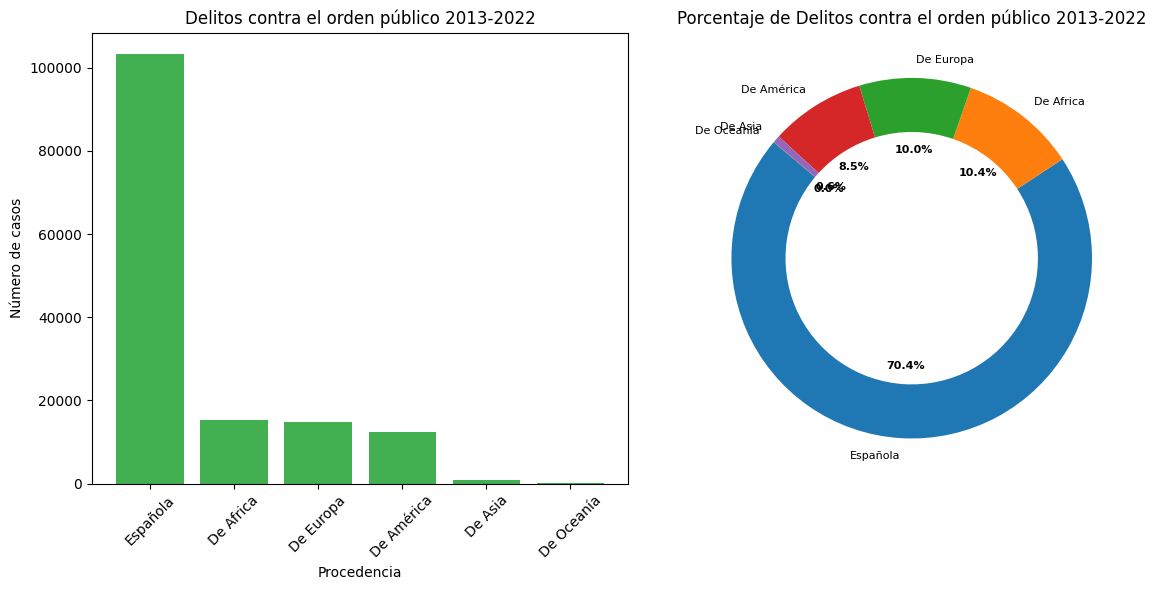

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(orden_publico_general["nacionalidad"], orden_publico_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos contra el orden público 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

orden_publico_general["porcentaje"] = round(orden_publico_general["total"] / orden_publico_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(orden_publico_general["porcentaje"], labels=orden_publico_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Delitos contra el orden público 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

In [36]:
orden_publico

,tipo_delito,nacionalidad,periodo,total
0,Contra el orden público,De Africa,2013,1218
1,Contra el orden público,De Africa,2014,1249
2,Contra el orden público,De Africa,2015,1266
3,Contra el orden público,De Africa,2016,1366
4,Contra el orden público,De Africa,2017,1411
5,Contra el orden público,De Africa,2018,1478
6,Contra el orden público,De Africa,2019,1573
7,Contra el orden público,De Africa,2020,1392
8,Contra el orden público,De Africa,2021,2041
9,Contra el orden público,De Africa,2022,2300
